# Plot Frontend

Plots statistics and data collected from the frontend related to feature detection,
RANSAC pose recovery, sparse stereo matching and timing.

In [43]:
import yaml
import os
import copy
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

import plotly.graph_objects as go

import evaluation.tools as evt
from evaluation.evaluation_lib import (
    get_ape_trans, 
    get_ape_rot, 
    plot_metric, 
    convert_abs_traj_to_rel_traj, 
    convert_rel_traj_from_body_to_cam
)

%matplotlib inline
# %matplotlib notebookw_T_bi
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [44]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "logs"
gt_data_file = "logs/traj_gt.csv"
left_cam_calibration_file = "params/LeftCameraParams.yaml"

## Frontend Statistics

Calculate and plot important statistics from the frontend of the VIO module

These statistics include the number of tracked and detected features, data relating the RANSAC runs for both mono 5-point and stereo 3-point methods, timing data and sparse-stereo-matching statistics.

In [45]:
# Parse frontend statistics csv file.
stats_file = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_stats.csv")

# Convert to tidy pandas DataFrame object.
df_stats = pd.read_csv(stats_file, sep=',', index_col=False)
df_stats.head()

#timestamp_lkf    mono_status stereo_status  nr_keypoints  \
0  1607119434715707188  LOW_DISPARITY         VALID           801   
1  1607119434984792483  LOW_DISPARITY         VALID           802   
2  1607119435255994528  LOW_DISPARITY         VALID           803   
3  1607119435625365907  LOW_DISPARITY         VALID           799   
4  1607119435913425218  LOW_DISPARITY         VALID           801   

   nrDetectedFeatures  nrTrackerFeatures  nrMonoInliers  nrMonoPutatives  \
0                   0                788            787              788   
1                   0                801            801              801   
2                   0                802            802              802   
3                   0                803            790              803   
4                   0                799            787              799   

   nrStereoInliers  nrStereoPutatives  ...  nrNoRightRectRKP  nrNoDepthRKP  \
0               15                532  ...                21           188   
1                5                 26  ...                21           188   
2               20                522  ...                21           188   
3               10                 42  ...                23           190   
4               21                506  ...                23           191   

   nrFailedArunRKP  featureDetectionTime  featureTrackingTime  monoRansacTime  \
0              516                     0                    6               1   
1               21                     0                    6               1   
2              501                     0                    8               0   
3               32                     0                    6               0   
4              485                     0                    6               0   

   stereoRansacTime  featureSelectionTime  extracted_corners  need_n_corners  
0                 1                     0                  0               0  
1                 0                     0                  0               0  
2                 1                     0                  0               0  
3                 0                     0                  0               0  
4                 1                     0                  0               0  

[5 rows x 24 columns]

In [46]:
# Helper functions for processing data summary.
def get_mean(attrib):
    ls = df_stats[attrib].tolist()
    return float(sum(ls)) / len(ls)

def get_min(attrib):
    return min(df_stats[attrib])

def get_max(attrib):
    return max(df_stats[attrib])

# Construct and visualize summary. TODO(marcus): use a LaTeX table.
summary_stats = [
    ("Average number of detected features", get_mean("nrDetectedFeatures")),
    ("Minimum number of detected features", get_min("nrDetectedFeatures")),
    ("Average number of tracked features" , get_mean("nrTrackerFeatures")),
    ("Minimum number of tracked features", get_min("nrTrackerFeatures")),
    ("Average number of mono ransac inliers", get_mean("nrMonoInliers")),
    ("Minimum number of mono ransac inliers", get_min("nrMonoInliers")),
    ("Average number of stereo ransac inliers", get_mean("nrStereoInliers")),
    ("Minimum number of stereo ransac inliers", get_min("nrStereoInliers")),
    ("Average number of mono ransac putatives", get_mean("nrMonoPutatives")),
    ("Minimum number of mono ransac putatives", get_min("nrMonoPutatives")),
    ("Average number of stereo ransac putatives", get_mean("nrStereoPutatives")),
    ("Minimum number of stereo ransac putatives", get_min("nrStereoPutatives")),
]

attrib_len = [len(attrib[0]) for attrib in summary_stats]
max_attrib_len = max(attrib_len)

print("\nStatistic summary:\n")
for entry in summary_stats:
    attrib = entry[0]
    value = entry[1]
    spacing = max_attrib_len - len(attrib)
    print(attrib + " "*spacing + ": " + str(value))


Statistic summary:

Average number of detected features      : 0.0
Minimum number of detected features      : 0
Average number of tracked features       : 778.527777778
Minimum number of tracked features       : 532
Average number of mono ransac inliers    : 618.466666667
Minimum number of mono ransac inliers    : 233
Average number of stereo ransac inliers  : 5.50555555556
Minimum number of stereo ransac inliers  : 0
Average number of mono ransac putatives  : 778.527777778
Minimum number of mono ransac putatives  : 532
Average number of stereo ransac putatives: 209.527777778
Minimum number of stereo ransac putatives: 26


In [47]:
# Plot feature tracking statistics.
use_plotly = False

if not use_plotly:
    fig0, axes0 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), squeeze=False)
    df_stats.plot(kind="line", y="nrDetectedFeatures", ax=axes0[0,0])
    df_stats.plot(kind="line", y="nrTrackerFeatures", ax=axes0[0,0])
    plt.show()
else:
    evt.draw_feature_tracking_stats(df_stats, True)


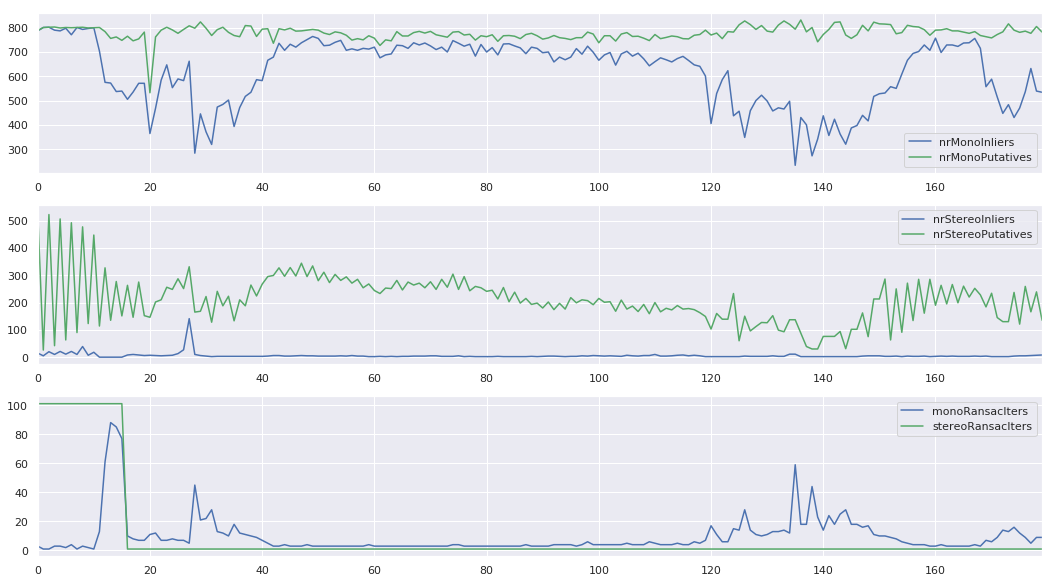

In [48]:
# Plot ransac inlier, putative and iteration statistics.
if not use_plotly:
    fig1, axes1 = plt.subplots(nrows=3, ncols=1, figsize=(18,10), squeeze=False)
    df_stats.plot(kind="line", y="nrMonoInliers", ax=axes1[0,0])
    df_stats.plot(kind="line", y="nrMonoPutatives", ax=axes1[0,0])
    df_stats.plot(kind="line", y="nrStereoInliers", ax=axes1[1,0])
    df_stats.plot(kind="line", y="nrStereoPutatives", ax=axes1[1,0])
    df_stats.plot(kind="line", y="monoRansacIters", ax=axes1[2,0])
    df_stats.plot(kind="line", y="stereoRansacIters", ax=axes1[2,0])
    plt.show()
else:
    evt.draw_mono_stereo_inliers_outliers(df_stats, True)

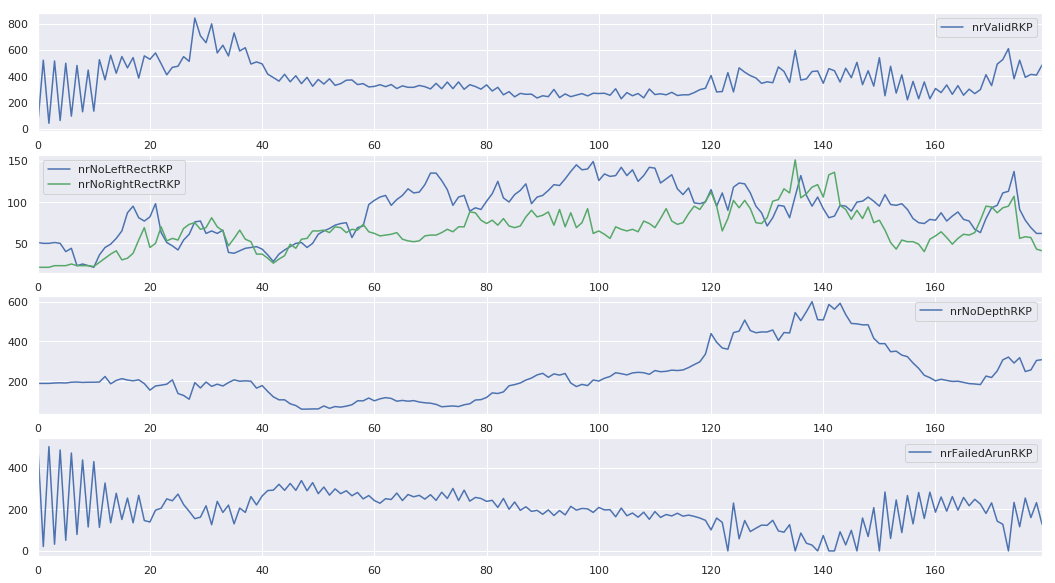

In [49]:
# Plot sparse-stereo-matching statistics.

fig3, axes3 = plt.subplots(nrows=4, ncols=1, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="nrValidRKP", ax=axes3[0,0])
df_stats.plot(kind="line", y="nrNoLeftRectRKP", ax=axes3[1,0])
df_stats.plot(kind="line", y="nrNoRightRectRKP", ax=axes3[1,0])
df_stats.plot(kind="line", y="nrNoDepthRKP", ax=axes3[2,0])
df_stats.plot(kind="line", y="nrFailedArunRKP", ax=axes3[3,0])

plt.show()

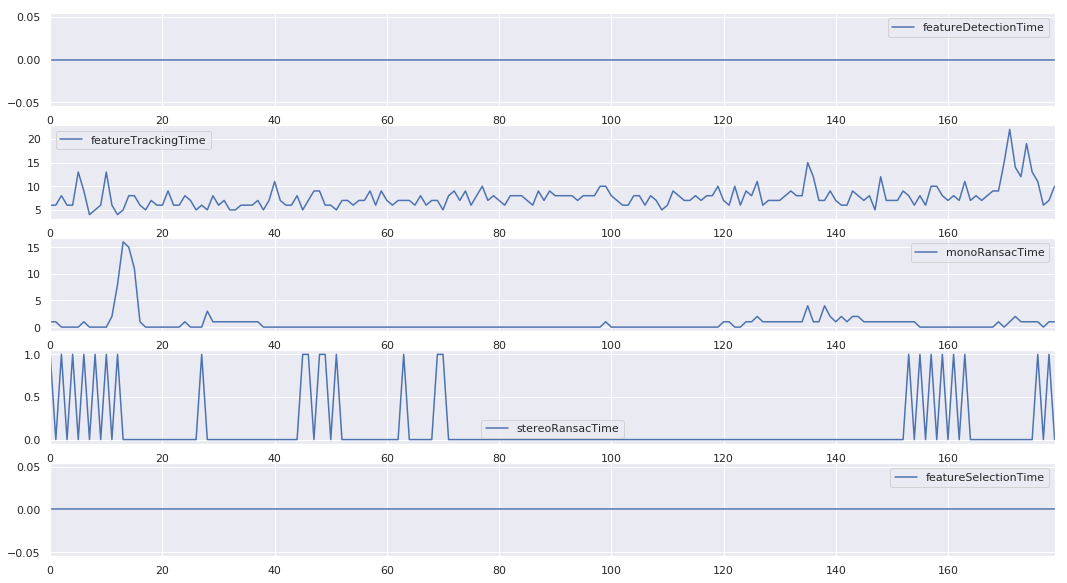

In [50]:
# Plot timing statistics.
if not use_plotly:
    fig2, axes2 = plt.subplots(nrows=5, ncols=1, figsize=(18,10), squeeze=False)
    df_stats.plot(kind="line", y="featureDetectionTime", ax=axes2[0,0])
    df_stats.plot(kind="line", y="featureTrackingTime", ax=axes2[1,0])
    df_stats.plot(kind="line", y="monoRansacTime", ax=axes2[2,0])
    df_stats.plot(kind="line", y="stereoRansacTime", ax=axes2[3,0])
    df_stats.plot(kind="line", y="featureSelectionTime", ax=axes2[4,0])
    plt.show()
else:
    evt.draw_frontend_timing(df_stats, True)

## Frontend Mono RANSAC

This section shows the performance of mono RANSAC portion of the pipeline.

We import the csv data as Pandas DataFrame objects and perform our own data association. Relative poses for ground truth data are computed explicitly here. Rotation error and translation error (up to a scaling factor) are then calculated for each pair of consecutive keyframes.

This gives insight into the accuracy of the RANSAC 5-point method employed in the frontend.

NOTE: gt_df is read from the ground-truth csv. It expects the timestamp to be the first column. Make sure to comment out `rename_euroc_gt_df(gt_df)` in the second cell below if you are not using a csv with the EuRoC header.

In [51]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

ransac_mono_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_ransac_mono.csv")
mono_df = pd.read_csv(ransac_mono_filename, sep=',', index_col=0)

# Load calibration data
with open(left_cam_calibration_file) as f:
    f.readline() # skip first line
    left_calibration_data = yaml.safe_load(f)
    body_T_leftCam = np.reshape(np.array(left_calibration_data['T_BS']['data']), (4,4))
    print("Left cam calibration matrix: ")
    print(body_T_leftCam)

Left cam calibration matrix: 
[[ 1.   0.   0.  -0.1]
 [ 0.   0.   1.   0.5]
 [ 0.  -1.   0.   0.2]
 [ 0.   0.   0.   1. ]]


In [52]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [53]:
# Generate some trajectories for later plots
# Convert to evo trajectory objects
traj_ref_unassociated = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
traj_est_unassociated = pandas_bridge.df_to_trajectory(mono_df)

# Associate the trajectories
traj_ref_abs, traj_est_rel = sync.associate_trajectories(traj_ref_unassociated, traj_est_unassociated)

traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref_abs, up_to_scale=False)
# traj_est_abs = co <<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Transform the relative gt trajectory from body to left camera frame
traj_ref_cam_rel =  convert_rel_traj_from_body_to_cam(traj_ref_rel, body_T_leftCam)

# Remove the first timestamp; we don't have relative pose at first gt timestamp
traj_est_rel = trajectory.PoseTrajectory3D(traj_est_rel._positions_xyz[1:],
                                           traj_est_rel._orientations_quat_wxyz[1:],
                                           traj_est_rel.timestamps[1:])

# print("traj_ref_rel: ", traj_ref_rel)
# print("traj_ref_cam_rel: ", traj_ref_cam_rel)
# print("traj_est_rel: ", traj_est_rel)

# Frames of trajectories:
# traj_rel_rel: body frame relative poses
# traj_ref_cam_rel: left camera frame relative poses
# traj_est_rel: left camera frame relative poses

# Save this relative-pose ground truth file to disk as a csv for later use, if needed.
# gt_rel_filename = "/home/marcus/output_gt_rel_poses_mono.csv"
# gt_rel_df.to_csv(filename, sep=',', columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])

### Frontend Mono and GT Relative Angles
This plot shows the relative angles from one frame to another from both mono RANSAC and ground-truth data. Note that the magnitudes of both lines should align very closely with each other. This plot is not affected by extrinsic calibration (as it is showing the relative angles). It can be used as an indicator for whether mono RANSAC is underestimating/overestimating the robot's rotations.

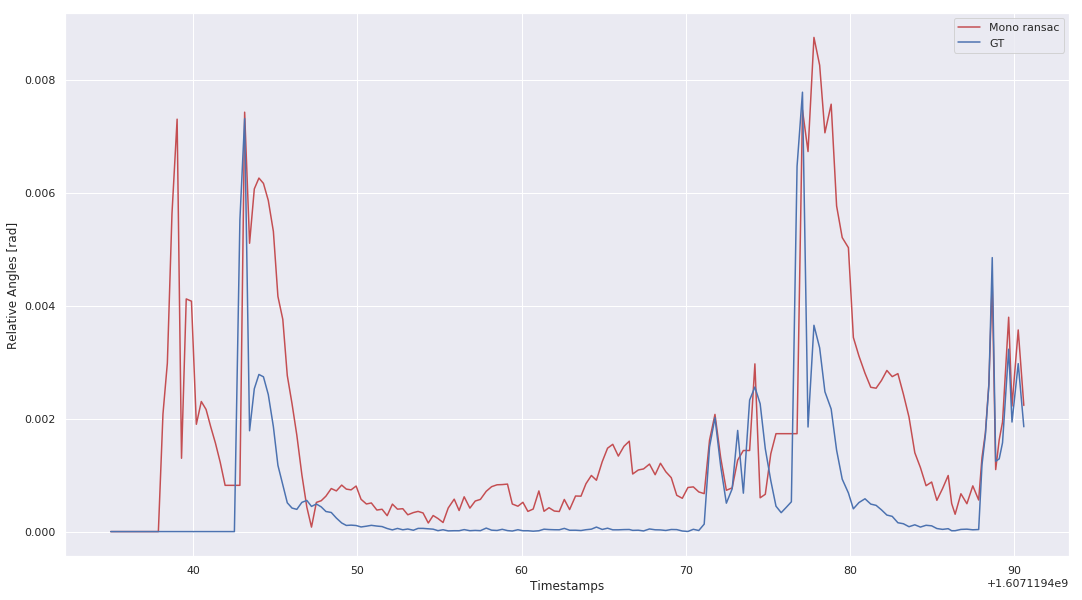

In [54]:
# Plot the mono ransac angles
mono_ransac_angles = []
mono_ransac_angles_timestamps = []
for i in range(len(traj_est_rel._orientations_quat_wxyz)):
    mono_ransac_angles_timestamps.append(traj_est_rel.timestamps[i])
    # quaternion to axisangle
    quat = traj_est_rel._orientations_quat_wxyz[i]
    r = R.from_quat([quat[1], quat[2], quat[3], quat[0]])
    rot_vec = r.as_rotvec()
    mono_ransac_angles.append(np.linalg.norm(rot_vec))


# Plot the GT angles
gt_angles = []
gt_angles_timestamps = []
for i in range(len(traj_ref_rel._poses_se3)):
    gt_angles_timestamps.append(traj_ref_rel.timestamps[i])
    # rotation matrix to axisangle
    rotm = traj_ref_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    gt_angles.append(np.linalg.norm(rot_vec))

    
plt.figure(figsize=(18, 10))
plt.plot(mono_ransac_angles_timestamps, mono_ransac_angles, 'r', label='Mono ransac')
plt.plot(gt_angles_timestamps, gt_angles, 'b',  label='GT')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('Relative Angles [rad]')

plt.show()

### Mono Relative-pose Errors (RPE)

Calculate relative-pose-error (RPE) for the mono ransac poses obtained in the frontend.

These are relative poses between keyframes and do not represent an entire trajectory. As such, they cannot be processed using the normal EVO evaluation pipeline.


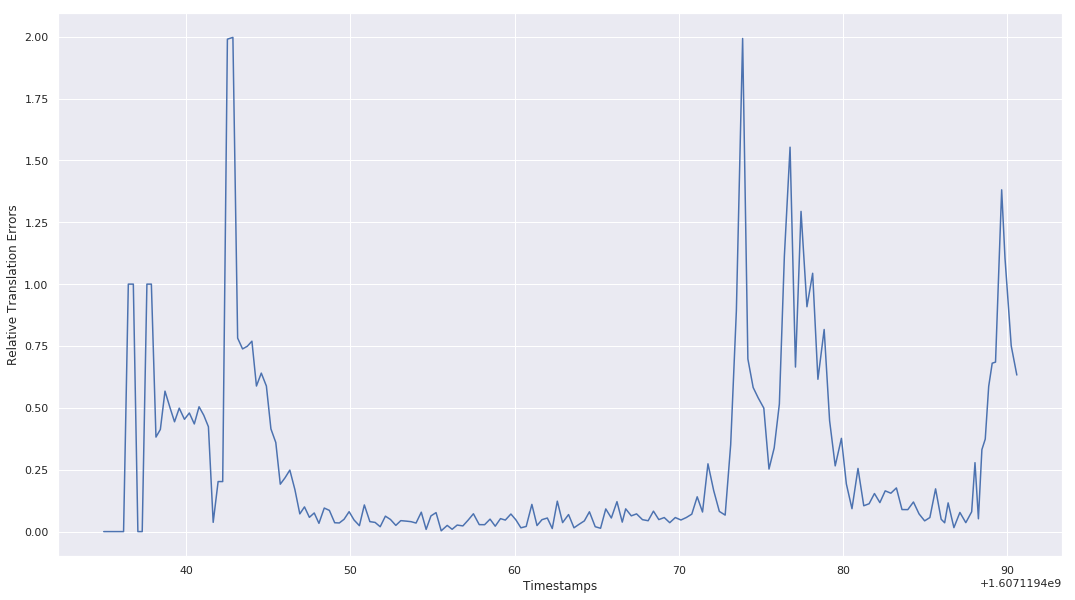

In [55]:
# Get RPE for entire relative trajectory.
ape_rot = get_ape_rot((traj_ref_cam_rel, traj_est_rel))
ape_tran = get_ape_trans((traj_ref_cam_rel, traj_est_rel))

# calculate the translation errors up-to-scale
trans_errors = []
for i in range(len(traj_ref_cam_rel.timestamps)):
    
    # normalized translation vector from gt
    t_ref = traj_ref_cam_rel.poses_se3[i][0:3,3]
    if np.linalg.norm(t_ref) > 1e-6:
        t_ref /= np.linalg.norm(t_ref)
    
    # normalized translation vector from mono ransac
    t_est = traj_est_rel.poses_se3[i][0:3,3] 
    if np.linalg.norm(t_est) > 1e-6:
        t_est /= np.linalg.norm(t_est)
        
    # calculate error (up to scale, equivalent to the angle between the two translation vectors)
    trans_errors.append(np.linalg.norm(t_ref - t_est))
    
plt.figure(figsize=(18, 10))
plt.plot(traj_ref_cam_rel.timestamps, trans_errors)
# plt.xlim(3370, 3450)
# plt.ylim(0, 0.17)

ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('Relative Translation Errors')

plt.show()


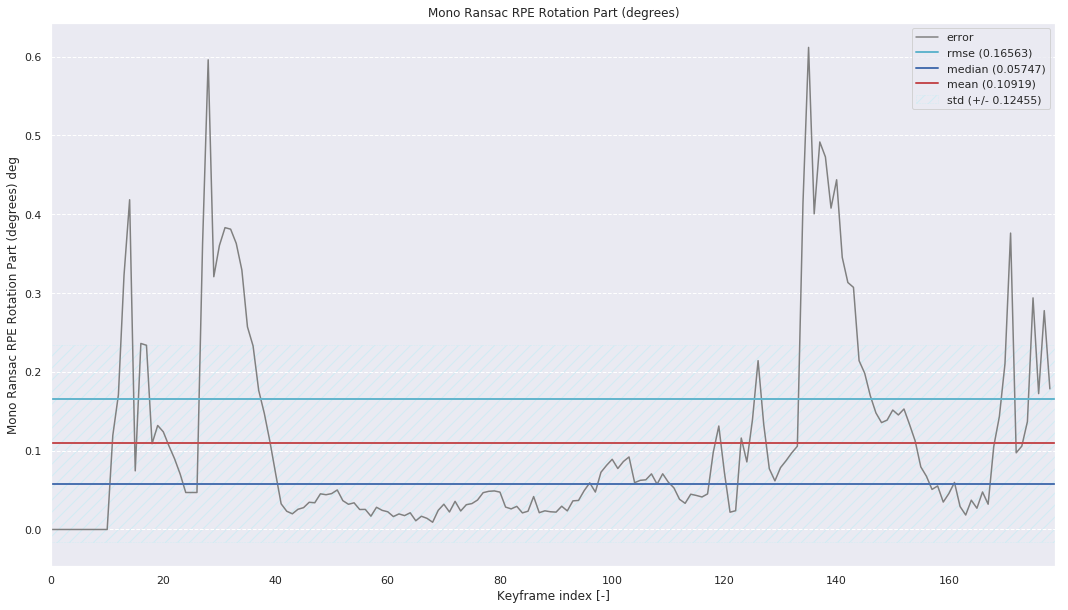

In [56]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est_rel.timestamps[0] for t in traj_est_rel.timestamps]

fig1 = plot_metric(ape_rot, "Mono Ransac RPE Rotation Part (degrees)", figsize=(18,10))
#fig2 = plot_metric(ape_tran, "Mono Ransac RPE Translation Part (meters)", figsize=(18,10))
plt.show()

## Frontend Stereo RANSAC Poses (RPE)

Calculate relative-pose-error (RPE) for the stereo ransac poses obtained in the frontend.

This is done in the same way as in the mono module.

This gives insight into the accuracy of the RANSAC 3-point method employed in the frontend.

NOTE: gt_df is read from the ground-truth csv. It expects the timestamp to be the first column. Make sure to comment out `rename_euroc_gt_df(gt_df)` in the second cell below if you are not using a csv with the EuRoC header.

In [57]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

ransac_stereo_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_ransac_stereo.csv")
stereo_df = pd.read_csv(ransac_stereo_filename, sep=',', index_col=0)

In [58]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [59]:
# Convert to evo trajectory objects
traj_ref_unassociated = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
traj_est_unassociated = pandas_bridge.df_to_trajectory(stereo_df)

# Associate the trajectories
traj_ref_abs, traj_est_rel = sync.associate_trajectories(traj_ref_unassociated, traj_est_unassociated)

traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref_abs)

# Remove the first timestamp; we don't have relative pose at first gt timestamp
traj_est_rel = trajectory.PoseTrajectory3D(traj_est_rel._positions_xyz[1:],
                                           traj_est_rel._orientations_quat_wxyz[1:],
                                           traj_est_rel.timestamps[1:])

print("traj_ref_rel: ", traj_ref_rel)
print("traj_est_rel: ", traj_est_rel)

# Convert the absolute poses (world frame) of the gt DataFrame to relative poses.

# Save this relative-pose ground truth file to disk as a csv for later use, if needed.
# gt_rel_filename = "/home/marcus/output_gt_rel_poses_stereo.csv"
# gt_rel_df.to_csv(filename, sep=',', columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])

('traj_ref_rel: ', <evo.core.trajectory.PoseTrajectory3D object at 0x7fc2b94157d0>)
('traj_est_rel: ', <evo.core.trajectory.PoseTrajectory3D object at 0x7fc2b87eeb10>)


In [60]:
# Get RPE for entire relative trajectory.
rpe_rot = get_ape_rot((traj_ref_rel, traj_est_rel))
rpe_tran = get_ape_trans((traj_ref_rel, traj_est_rel))

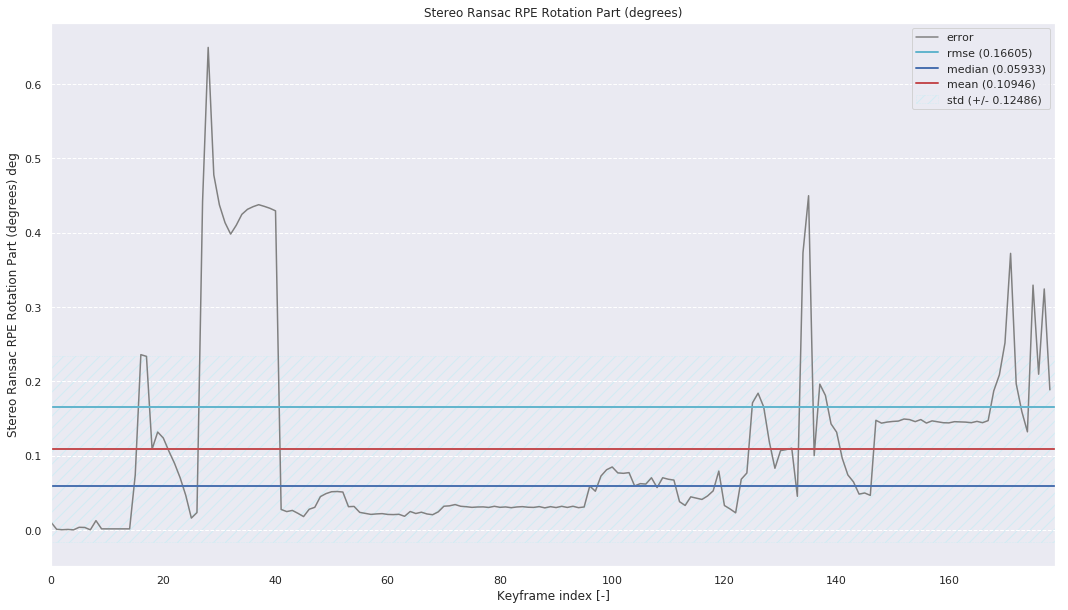

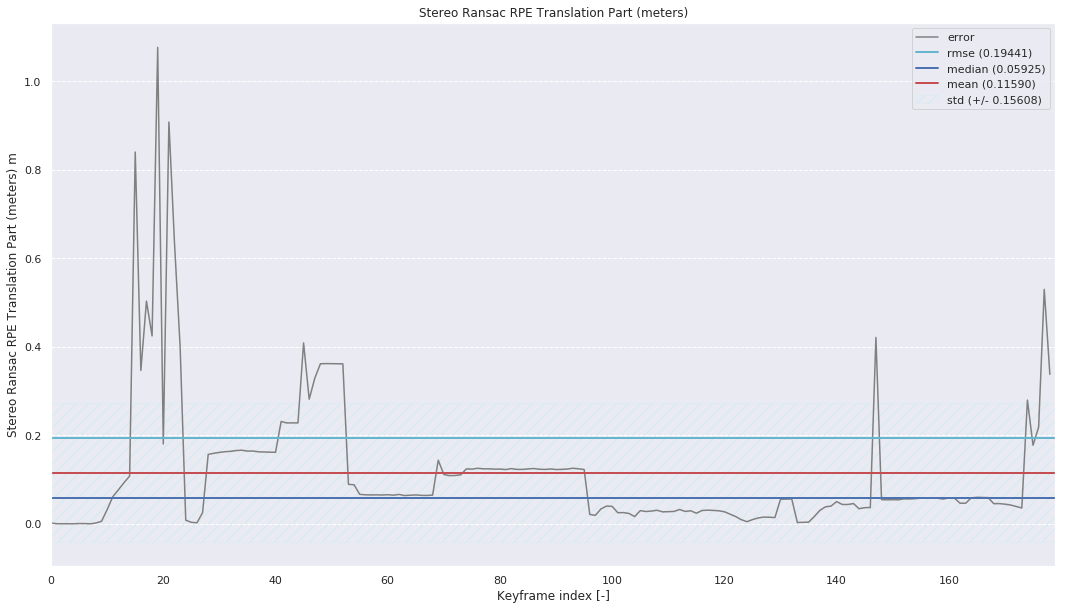

In [61]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est_rel.timestamps[0] for t in traj_est_rel.timestamps]

plot_metric(rpe_rot, "Stereo Ransac RPE Rotation Part (degrees)", figsize=(18,10))
plot_metric(rpe_tran, "Stereo Ransac RPE Translation Part (meters)", figsize=(18,10))
plt.show()